<a href="https://colab.research.google.com/github/gabilodeau/INF6804/blob/master/Keypoint_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INF6804 Vision par ordinateur

Polytechnique Montréal

Author: Soufiane Lamghari






Description : This notebook implements Keypoint R-CNN for human pose estimation in inference, using ResNet50 as the backbone network (pre-trained on the MS COCO dataset). In this example, we predict human poses for some sample images.

import libraries

In [2]:
import os
from os.path import exists, join, basename, splitext
from skimage import io
import random
import PIL
import torchvision
import cv2
import numpy as np
import torch
import time
import matplotlib
import matplotlib.pylab as plt


Load the model, the backbone is ResNet50 pre-trained on MS COCO. 

In [3]:
torch.set_grad_enabled(False)
plt.rcParams["axes.grid"] = False
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
model = model.eval().cuda()

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


Visualization function, used to draw the predicted poses over the RGB source images

In [4]:
if not exists('keypoint.py'):
  !wget https://raw.githubusercontent.com/facebookresearch/maskrcnn-benchmark/e0a525a0139baf7086117b7ed3fd318a4878d71c/maskrcnn_benchmark/structures/keypoint.py
    
from keypoint import PersonKeypoints
def vis_keypoints(img, kps, kp_thresh=2, alpha=0.7):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    dataset_keypoints = PersonKeypoints.NAMES
    kp_lines = PersonKeypoints.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)

    # Draw mid shoulder / mid hip first for better visualization.
    mid_shoulder = (
        kps[:2, dataset_keypoints.index('right_shoulder')] +
        kps[:2, dataset_keypoints.index('left_shoulder')]) / 2.0
    sc_mid_shoulder = np.minimum(
        kps[2, dataset_keypoints.index('right_shoulder')],
        kps[2, dataset_keypoints.index('left_shoulder')])
    mid_hip = (
        kps[:2, dataset_keypoints.index('right_hip')] +
        kps[:2, dataset_keypoints.index('left_hip')]) / 2.0
    sc_mid_hip = np.minimum(
        kps[2, dataset_keypoints.index('right_hip')],
        kps[2, dataset_keypoints.index('left_hip')])
    nose_idx = dataset_keypoints.index('nose')
    if sc_mid_shoulder > kp_thresh and kps[2, nose_idx] > kp_thresh:
        cv2.line(
            kp_mask, tuple(mid_shoulder), tuple(kps[:2, nose_idx]),
            color=colors[len(kp_lines)], thickness=2, lineType=cv2.LINE_AA)
    if sc_mid_shoulder > kp_thresh and sc_mid_hip > kp_thresh:
        cv2.line(
            kp_mask, tuple(mid_shoulder), tuple(mid_hip),
            color=colors[len(kp_lines) + 1], thickness=2, lineType=cv2.LINE_AA)

    # Draw the keypoints
    for l in range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
            cv2.line(
                kp_mask, p1, p2,
                color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=3, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        if kps[2, i2] > kp_thresh:
            cv2.circle(
                kp_mask, p2,
                radius=3, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)
  
  
def overlay_keypoints(image, kps, scores):
  kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).cpu().numpy()
  for region in kps:
    image = vis_keypoints(image, region.transpose((1, 0)))
  return image

--2020-11-19 21:30:47--  https://raw.githubusercontent.com/facebookresearch/maskrcnn-benchmark/e0a525a0139baf7086117b7ed3fd318a4878d71c/maskrcnn_benchmark/structures/keypoint.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6555 (6.4K) [text/plain]
Saving to: ‘keypoint.py’

keypoint.py         100%[===================>]   6.40K  --.-KB/s    in 0s      

2020-11-19 21:30:47 (82.7 MB/s) - ‘keypoint.py’ saved [6555/6555]



Get images (here from the github of INF6804 course) and transform them as torch tensors. Then get the predictions and display the predicted poses

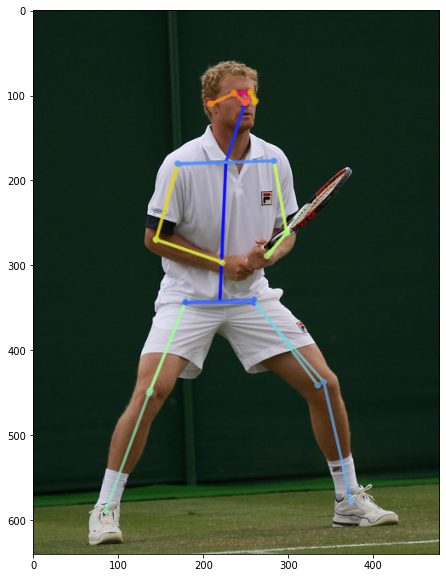

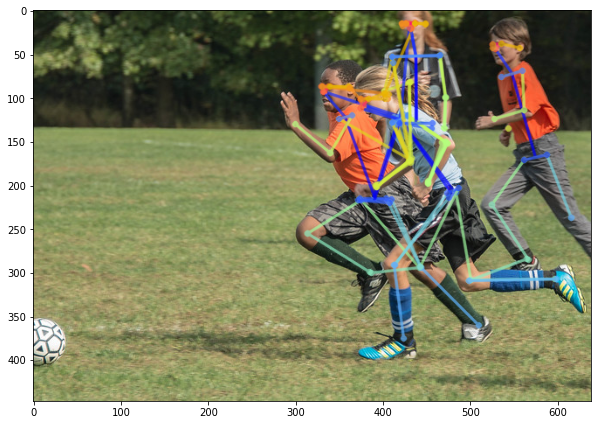

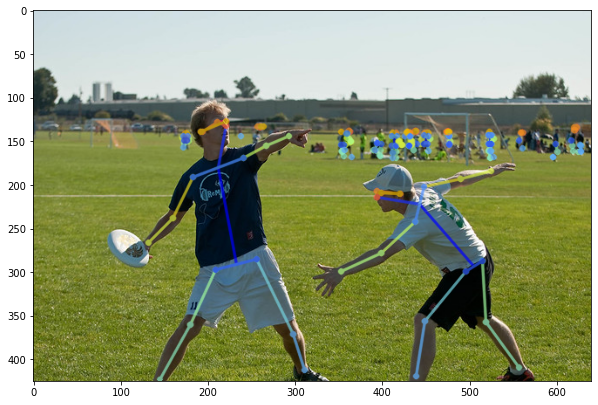

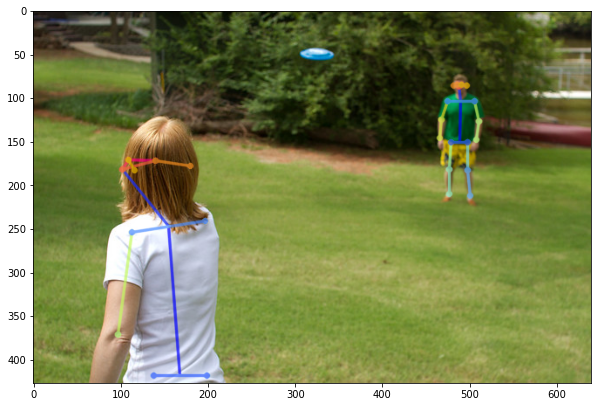

In [5]:
source = 'https://raw.githubusercontent.com/gabilodeau/INF6804/master/images'

examples = ['tennis2.jpg','soccer.jpg','frisbee1.jpg','frisbee2.jpg']

for img in examples:
  
  # Load test images
  image = io.imread(os.path.join(source, img))

  # Run Keypoint R-CNN model on the set of test images
  image_tensor = torchvision.transforms.functional.to_tensor(image).cuda()
  output = model([image_tensor])[0]
  result_image = np.array(image.copy())
  result_image = overlay_keypoints(result_image, output['keypoints'], output['keypoints_scores'])

  # show the results
  plt.figure(figsize=(10, 10))
  plt.imshow(result_image) 


**References:**

 - https://pytorch.org/docs/stable/torchvision/models.html

 - https://github.com/facebookresearch/maskrcnn-benchmark

 - [Keypoint R-CNN paper](https://arxiv.org/abs/1703.06870)